In [ ]:
! python3 -m pip install --upgrade pip
! python3 -m pip install --upgrade SpeechRecognition
! python3 -m pip install --upgrade pydub
! python3 -m pip install --upgrade sklearn


     |████████████████████████████████| 1.5MB 5.8MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 32.8 MB 66 kB/s 


In [ ]:
import IPython.display as ipd
import librosa
import librosa.display
import kapre
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import io
import os
import pandas as pd
import random
import re
import shutil
import speech_recognition as sr
import tensorflow as tf
from os import listdir
from os.path import isfile, join
from os import path
from plotnine import *
from pydub import AudioSegment
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from pydub.silence import split_on_silence 

# Cloud storage
from google.cloud import storage


In [ ]:
# !pip install google-cloud-speech

In [ ]:
# Import speech to text ibraries
# from google.cloud import speech
# from google.cloud.speech import enums
# from google.cloud.speech import types
# import wave

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Transcribe audio data to txt data

In [ ]:
# TODO make an input from user
# data_path = '/tf/dementia/0extra/ADReSS-IS2020-train/ADReSS-IS2020-data/train'
data_path = '/content/drive/My Drive/Berkeley/W210/Capstone/ADReSS-IS2020-data/train'

audio_path_cc = data_path + '/Full_wave_enhanced_audio/cc/'
audio_path_cd = data_path + '/Full_wave_enhanced_audio/cd/'


text_path_cc = data_path + '/transcription/cc/'
text_path_cd = data_path + '/transcription/cd/'

lang_ = 'en-US'

r = sr.Recognizer()

In [ ]:
meta_cc = pd.read_csv(data_path + '/cc_meta_data.txt', sep=";", header=0, 
                      names = ['ID', 'Age', 'Gender', 'MMSE'])
meta_cd = pd.read_csv(data_path + '/cd_meta_data.txt', sep=";", header=0, 
                      names = ['ID', 'Age', 'Gender', 'MMSE'])

meta = meta_cc.assign(Group = 'cc').append(meta_cd.assign(Group = 'cd')).reset_index()

meta['ID'] = meta['ID'].str.strip()

meta

,index,ID,Age,Gender,MMSE,Group
0,0,S001,74,male,NA,cc
1,1,S002,62,female,30,cc
2,2,S003,69,female,29,cc
3,3,S004,71,female,30,cc
4,4,S005,74,female,30,cc
...,...,...,...,...,...,...
103,49,S150,58,male,20,cd
104,50,S151,72,male,24,cd
105,51,S153,68,female,12,cd
106,52,S154,65,female,20,cd


In [ ]:
sum(meta.MMSE == ' NA')

1

In [ ]:
meta.MMSE = pd.to_numeric(meta.MMSE.replace(' NA', 30))
meta

,index,ID,Age,Gender,MMSE,Group
0,0,S001,74,male,30,cc
1,1,S002,62,female,30,cc
2,2,S003,69,female,29,cc
3,3,S004,71,female,30,cc
4,4,S005,74,female,30,cc
...,...,...,...,...,...,...
103,49,S150,58,male,20,cd
104,50,S151,72,male,24,cd
105,51,S153,68,female,12,cd
106,52,S154,65,female,20,cd


In [ ]:
meta.dtypes

index      int64
ID        object
Age        int64
Gender    object
MMSE       int64
Group     object
dtype: object

In [ ]:
# !ls '/content/drive/My Drive/Berkeley/W210/Capstone/ADReSS-IS2020-data/train/Full_wave_enhanced_audio/cd/'

In [ ]:
# a function that splits the audio file into chunks 
# and applies speech recognition 
def silence_based_conversion(path, wav_file): 
    text_df = pd.DataFrame()
  
    # open the audio file stored in 
    # the local system as a wav file. 
    song = AudioSegment.from_wav(path + wav_file) 
    print(song)
  
    # open a file where we will concatenate   
    # and store the recognized text 
    text_file = wav_file.partition('.')[0] + ".txt"
    text_file_dir = path + "output_text/" 
    if not os.path.exists(text_file_dir):
        os.makedirs(text_file_dir)    
    text_file_path = text_file_dir + text_file
    fh = open(text_file_path, "w+") 
          

    dBFS = song.dBFS
    print('dBFS: ' + str(dBFS))
    # chunks = split_on_silence(song, 
    #     min_silence_len = 500,
    #     silence_thresh = dBFS-16,
    #     keep_silence = 250 
    # )

    # split track where silence is 0.5 seconds  
    # or more and get chunks 
    chunks = split_on_silence(song, 
        # must be silent for at least 0.5 seconds 
        # or 500 ms. adjust this value based on user 
        # requirement. if the speaker stays silent for  
        # longer, increase this value. else, decrease it. 
        min_silence_len = 250, 
  
        # consider it silent if quieter than -16 dBFS 
        # adjust this per requirement 
        silence_thresh = dBFS - 16
        # keep_silence = 250
    ) 
    # setting minimum length of each chunk to 25 seconds
    target_length = 20 * 1000 
    output_chunks = [chunks[0]]
    for chunk in chunks[1:]:
      print('Length of chunk: ' + str(len(output_chunks[-1])) )
      if len(output_chunks[-1]) < target_length:
        output_chunks[-1] += chunk
      else:
        # if the last output chunk is longer than the target length,
        # we can start a new one
        output_chunks.append(chunk)    
    # print(chunks)
  
    # create a directory to store the audio chunks. 
    try: 
        os.mkdir(path + 'audio_chunks') 
    except(FileExistsError): 
        pass
  
    # move into the directory to 
    # store the audio files. 
    os.chdir(path +'audio_chunks') 
  
    i = 0
    # process each chunk 
    for chunk in output_chunks: 
              
        # Create 0.5 seconds silence chunk 
        chunk_silent = AudioSegment.silent(duration = 10) 
  
        # add 0.5 sec silence to beginning and  
        # end of audio chunk. This is done so that 
        # it doesn't seem abruptly sliced. 
        audio_chunk = chunk_silent + chunk + chunk_silent 
  
        # export audio chunk and save it in  
        # the current directory. 
        text_file_id = text_file.partition('.')[0]
        chunk_file_name = text_file_id + "_" + "chunk" + str(i) + ".wav"
        print("saving " + chunk_file_name) 
        # specify the bitrate to be 192 k 
        audio_chunk.export("./" + chunk_file_name, bitrate ='192k', format ="wav") 
  
        # the name of the newly created chunk 
        filename = chunk_file_name
  
        print("Processing chunk file: " + filename) 
  
        # get the name of the newly created chunk 
        # in the AUDIO_FILE variable for later use. 
        file = filename 
  
        # create a speech recognition object 
        r = sr.Recognizer() 
  
        # recognize the chunk 
        with sr.AudioFile(file) as source: 
            # remove this if it is not working 
            # correctly. 
            #r.adjust_for_ambient_noise(source) 
            audio_listened = r.record(source) 
  
        try: 
            # try converting it to text 
            rec = r.recognize_google(audio_listened) 
            # write the output to the file. 
            fh.write(rec+". ") 
            text_df = text_df.append({'ID': text_file_id, 'Text': rec}, ignore_index = True)
  
        # catch any errors. 
        except sr.UnknownValueError: 
            print("Could not understand audio") 
  
        except sr.RequestError as e: 
            print("Could not request results. check your internet connection") 
  
        i += 1
    return text_df

# silence_based_conversion(audio_path_cc, 'S001.wav')        
# text_df = silence_based_conversion(audio_path_cd, 'S079.wav')        
# print(text_df)
# silence_based_conversion(audio_path_cc + 'spkr0.wav')        

In [ ]:
# temp_merged_data = meta[meta['ID'] == 'S079']
# print(temp_merged_data)

# temp_merged_data = pd.merge(temp_merged_data, text_df, on = "ID", how = "inner")
# print(temp_merged_data)

    index    ID  Age  Gender  MMSE Group
54      0  S079   59   male     11    cd
   index    ID  ...  Group                                               Text
0      0  S079  ...     cd  you see going on in the picture tell me all th...
1      0  S079  ...     cd  and it already is starting to fall over and so...
2      0  S079  ...     cd  he has a I can't think of the she has she's tr...

[3 rows x 7 columns]


In [ ]:
# def startConversion(path, filename, lang = lang_):
                
#     # Create output file name
#     output_dir = path + 'output_text/'
#     output_file = '.'.join(filename.split(sep='.')[:-1]) + '.txt'
#     output_file_path = output_dir + output_file
    
#     # If output file does not exist, continue
#     if os.path.exists(output_file_path):
#         print("Sorry, " + output_file_path + " already exists")
#     else:
#         full_path = path + filename

#         with sr.AudioFile(full_path) as source:
#             print('Transcribing file: ' + str(filename) + ' in path: ' + str(full_path))
#             audio_text = r.listen(source)
#             # recognize_() method will throw a request error if the API is unreachable, hence using exception handling
#             try:

#                 # using google speech recognition
#                 # print('Converting audio transcripts into text ...')
#                 text = r.recognize_google(audio_text)

#                 # Create output directory
#                 if not os.path.exists(output_dir):
#                     os.makedirs(output_dir)

#                 with open(output_file_path, 'w') as f:
#                     f.write(text)
#                 print('Finished transcribing text file ' + str(output_file) + ' at location ' + output_file_path)

#             except Exception as e:
#                 print('Error: ' + str(e) + ' <- this guy')

In [ ]:
split_id_text_df = pd.DataFrame()

In [ ]:
# Running for CC path
onlyfiles = [f for f in listdir(audio_path_cc) if isfile(join(audio_path_cc, f))]

for filename in onlyfiles:
    # startConversion(path = audio_path_cc, filename = filename)
    text_df = silence_based_conversion(path=audio_path_cc, wav_file=filename)
    split_id_text_df = split_id_text_df.append(text_df, ignore_index=True)

print(split_id_text_df)


dBFS: -29.536595460200303
Length of chunk: 2103
Length of chunk: 3452
Length of chunk: 3687
Length of chunk: 4649
Length of chunk: 5800
Length of chunk: 8553
Length of chunk: 9380
Length of chunk: 9976
Length of chunk: 10628
Length of chunk: 11166
Length of chunk: 13035
Length of chunk: 13844
Length of chunk: 14793
Length of chunk: 17087
Length of chunk: 20309
Length of chunk: 373
Length of chunk: 1659
Length of chunk: 2710
Length of chunk: 4690
Length of chunk: 6831
Length of chunk: 7762
Length of chunk: 10757
Length of chunk: 11865
Length of chunk: 13188
Length of chunk: 15975
Length of chunk: 17924
Length of chunk: 21843
Length of chunk: 955
Length of chunk: 4204
Length of chunk: 6487
Length of chunk: 9345
Length of chunk: 10668
Length of chunk: 12271
saving S001_chunk0.wav
Processing chunk file: S001_chunk0.wav
saving S001_chunk1.wav
Processing chunk file: S001_chunk1.wav
saving S001_chunk2.wav
Processing chunk file: S001_chunk2.wav
dBFS: -43.94773199993912
Length of chunk: 192
Len

In [ ]:
# Running for CD path
onlyfiles = [f for f in listdir(audio_path_cd) if isfile(join(audio_path_cd, f))]

for filename in onlyfiles:
    # startConversion(path = audio_path_cd, filename = filename)
    text_df = silence_based_conversion(path=audio_path_cd, wav_file=filename)
    split_id_text_df = split_id_text_df.append(text_df, ignore_index=True)


dBFS: -31.301701611671895
Length of chunk: 3434
Length of chunk: 4024
Length of chunk: 4643
Length of chunk: 6253
Length of chunk: 7598
Length of chunk: 8563
Length of chunk: 10576
Length of chunk: 11195
Length of chunk: 12510
Length of chunk: 13506
Length of chunk: 15282
Length of chunk: 16188
Length of chunk: 17085
Length of chunk: 19444
Length of chunk: 19756
Length of chunk: 21036
Length of chunk: 3002
Length of chunk: 4678
Length of chunk: 5223
Length of chunk: 7428
Length of chunk: 8654
Length of chunk: 9361
Length of chunk: 13460
Length of chunk: 14747
Length of chunk: 16651
Length of chunk: 18813
Length of chunk: 19888
Length of chunk: 20275
Length of chunk: 1227
Length of chunk: 1450
Length of chunk: 3680
Length of chunk: 4800
Length of chunk: 6710
Length of chunk: 7071
Length of chunk: 7476
Length of chunk: 7953
Length of chunk: 11711
Length of chunk: 12651
Length of chunk: 13368
saving S079_chunk0.wav
Processing chunk file: S079_chunk0.wav
saving S079_chunk1.wav
Processing c

In [ ]:
split_id_text_file_path = '/content/drive/My Drive/Berkeley/W210/Capstone/ADReSS-IS2020-data/train/Full_wave_enhanced_audio/split_id_text_df.csv'
split_id_text_df.to_csv(split_id_text_file_path)


In [ ]:
# os.listdir(audio_path_cc + "/output_text")

In [ ]:
# text_dict = {"ID": [], "Text": []}

# # CC path
# audio_cc_text_path = audio_path_cc + "output_text/"
# onlytextfiles_cc = [f for f in listdir(audio_cc_text_path) if isfile(join(audio_cc_text_path, f))]
        
# for filename in onlytextfiles_cc:
#     just_name = filename.split(sep='.')[:-1][0]
#     # print("Adding to dictionary: " + str(just_name))
#     full_text_file_path = audio_cc_text_path + filename

#     # Make all text lowercase
#     # Remove special characters
#     with open(full_text_file_path, "r") as file:
#         data = file.read().replace('\n', '')
#         text_dict["ID"].append(just_name)
#         text_dict["Text"].append(data)

# # CD path
# audio_cd_text_path = audio_path_cd + "output_text/"
# onlytextfiles_cd = [f for f in listdir(audio_cd_text_path) if isfile(join(audio_cd_text_path, f))]

# for filename in onlytextfiles_cd:
#     just_name = filename.split(sep='.')[:-1][0]
#     # print("Adding to dictionary: " + just_name)
#     full_text_file_path = audio_cd_text_path + filename

#     # Make all text lowercase
#     # Remove special characters
#     with open(full_text_file_path, "r") as file:
#         data = file.read().replace('\n', '')
#         text_dict["ID"].append(just_name)
#         text_dict["Text"].append(data)

# print("Done!")

In [ ]:
# # Convert the dictionary into DataFrame 
# text_df = pd.DataFrame(text_dict)
# # text_df['ID' == 'S001', 'Text']
# text_df

In [ ]:
split_id_text_df = pd.read_csv(split_id_text_file_path)
merged_data = pd.merge(meta, split_id_text_df, on = "ID", how = "inner")
merged_data

,index,ID,Age,Gender,MMSE,Group,Unnamed: 0,Text
0,0,S001,74,male,30,cc,0,tell me everything that you see going on in th...
1,0,S001,74,male,30,cc,1,crafts in the garden and their dishes are two ...
2,0,S001,74,male,30,cc,2,standing up there in a covered taking cookies ...
3,2,S003,69,female,29,cc,3,okay there's a little boy and he's getting he ...
4,2,S003,69,female,29,cc,4,the cupboard door is open to Liz crokin the wa...
...,...,...,...,...,...,...,...,...
202,51,S153,68,female,12,cd,203,and tell me everything that you see happening ...
203,51,S153,68,female,12,cd,204,Arizona schoolgirl with him and the the band S...
204,52,S154,65,female,20,cd,205,okay and the boys getting in the cookie jar is...
205,53,S156,71,female,13,cd,206,can you tell me now this one is in the cookie ...


In [ ]:

filtered_merged_data = merged_data[merged_data['Text'].apply(lambda x: len(x) > 0)]
filtered_merged_data


,index,ID,Age,Gender,MMSE,Group,Unnamed: 0,Text
0,0,S001,74,male,30,cc,0,tell me everything that you see going on in th...
1,0,S001,74,male,30,cc,1,crafts in the garden and their dishes are two ...
2,0,S001,74,male,30,cc,2,standing up there in a covered taking cookies ...
3,2,S003,69,female,29,cc,3,okay there's a little boy and he's getting he ...
4,2,S003,69,female,29,cc,4,the cupboard door is open to Liz crokin the wa...
...,...,...,...,...,...,...,...,...
202,51,S153,68,female,12,cd,203,and tell me everything that you see happening ...
203,51,S153,68,female,12,cd,204,Arizona schoolgirl with him and the the band S...
204,52,S154,65,female,20,cd,205,okay and the boys getting in the cookie jar is...
205,53,S156,71,female,13,cd,206,can you tell me now this one is in the cookie ...


In [ ]:
# merged_data[merged_data['ID'] == 'S007']['Text']

# Split dataset

# BERT Transfer Learning

In [ ]:
!pip install transformers==3.0.2

     |████████████████████████████████| 769 kB 5.9 MB/s 
     |████████████████████████████████| 883 kB 24.2 MB/s 
     |████████████████████████████████| 1.2 MB 37.9 MB/s 
     |████████████████████████████████| 3.0 MB 58.4 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-py3-none-any.whl size=893258 sha256=afe805f0d4732bd93a2ff3eea7bc4d88dbc077882520db36c7ca5cab5b642e0e
  Stored in directory: /root/.cache/pip/wheels/69/09/d1/bf058f7d6fa0ecba2ce7c66be3b8d012beb4bf61a6e0c101c0
Successfully built sacremoses


In [ ]:
from transformers import BertTokenizer
bert_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(bert_name,
                                          add_special_tokens=True,
                                          do_lower_case=True,
                                          max_length=256,
                                          pad_to_max_length=True)


In [ ]:
def bert_encoder(input_text):
    # txt = input_text.numpy().decode('utf-8')
    txt = input_text
    encoded = tokenizer.encode_plus(txt, add_special_tokens=True, 
                                    max_length=256, 
                                    pad_to_max_length=True, 
                                    return_attention_mask=True, 
                                    return_token_type_ids=True,
                                    truncation=True)
    return encoded['input_ids'], encoded['token_type_ids'], \
           encoded['attention_mask']

In [ ]:
bert_train = [bert_encoder(r) for r in filtered_merged_data["Text"]]
bert_lbl = filtered_merged_data["MMSE"]
bert_train = np.array(bert_train)
# bert_lbl = tf.keras.utils.to_categorical(bert_lbl)

In [ ]:
# bert_train
# bert_lbl

In [ ]:
# create training and validation splits
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(bert_train, 
                                         bert_lbl,
                                         test_size=0.2, 
                                         random_state=42)
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(165, 3, 256) (165,)
(42, 3, 256) (42,)


In [ ]:
# x_val.shape
# y_val.shape
# y_val

In [ ]:
tr_reviews, tr_segments, tr_masks = np.split(x_train, 3, axis=1)
val_reviews, val_segments, val_masks = np.split(x_val, 3, axis=1)
tr_reviews = tr_reviews.squeeze()
tr_segments = tr_segments.squeeze()
tr_masks = tr_masks.squeeze()
val_reviews = val_reviews.squeeze()
val_segments = val_segments.squeeze()
val_masks = val_masks.squeeze()

In [ ]:
def example_to_features(input_ids,attention_masks,token_type_ids,y):
  return {"input_ids": input_ids,
          "attention_mask": attention_masks,
          "token_type_ids": token_type_ids},y
train_ds = tf.data.Dataset.from_tensor_slices((tr_reviews, 
tr_masks, tr_segments, y_train)).\
            map(example_to_features).shuffle(100).batch(16)
valid_ds = tf.data.Dataset.from_tensor_slices((val_reviews, 
val_masks, val_segments, y_val)).\
            map(example_to_features).shuffle(100).batch(16)

In [ ]:
train_ds

<BatchDataset shapes: ({input_ids: (None, 256), attention_mask: (None, 256), token_type_ids: (None, 256)}, (None,)), types: ({input_ids: tf.int64, attention_mask: tf.int64, token_type_ids: tf.int64}, tf.int64)>

In [ ]:
# from transformers import TFBertForSequenceClassification
# bert_model = TFBertForSequenceClassification.from_pretrained(bert_name, num_labels=31)

In [ ]:
# # optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)

# # loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, name="sparse_categorical_crossentropy")
# # loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
# # metrics = tf.metrics.CategoricalCrossentropy()
# # bert_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
# optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=2e-5)
# bert_model.compile(optimizer = optimizer, 
#                    loss=tf.keras.metrics.mean_squared_error,
#                    metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])

In [ ]:
# print("Fine-tuning BERT on Training data")
# bert_history = bert_model.fit(train_ds, epochs=25, 
#                               validation_data=valid_ds)

In [ ]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model

def build_model(transformer, max_len=512):
    """
    https://www.kaggle.com/xhlulu/jigsaw-tpu-distilbert-with-huggingface-and-keras
    """
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(1, activation='relu')(cls_token)
#     run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)
    model = Model(inputs=input_word_ids, outputs=out)
    for layer in model.layers[:-1]:
      layer.trainable = False
    # model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy']) #, options = run_opts)
    # optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=2e-5)
    optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
    model.compile(optimizer = optimizer, 
                  loss=tf.keras.metrics.mean_squared_error,
                  metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])
    return model

In [ ]:
import transformers
MAX_LEN = 256
# with strategy.scope():
transformer_layer = (
    transformers.TFAutoModelWithLMHead.from_pretrained(bert_name)
)
model = build_model(transformer_layer, max_len=MAX_LEN)
model.summary()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing TFBertForMaskedLM: ['nsp___cls']
- This IS expected if you are initializing TFBertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertForMaskedLM were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 256)]             0         
_________________________________________________________________
tf_bert_for_masked_lm_1 (TFB ((None, 256, 30522),)     110104890 
_________________________________________________________________
tf.__operators__.getitem_1 ( (None, 30522)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 30523     
Total params: 110,135,413
Trainable params: 30,523
Non-trainable params: 110,104,890
_________________________________________________________________


In [ ]:
filtered_merged_data.shape

(207, 8)

In [ ]:
print("Fine-tuning BERT on Training data")
bert_history = model.fit(train_ds, epochs=50, 
                         validation_data=valid_ds)

Fine-tuning BERT on Training data
Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['attention_mask', 'token_type_ids'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


11/11 [==============================] - 16s 496ms/step - loss: 388.6844 - rmse: 19.6355 - val_loss: 80.9462 - val_rmse: 8.9970
Epoch 2/50
11/11 [==============================] - 3s 256ms/step - loss: 112.3340 - rmse: 10.5763 - val_loss: 171.2788 - val_rmse: 13.0874
Epoch 3/50
11/11 [==============================] - 3s 257ms/step - loss: 91.6052 - rmse: 9.5660 - val_loss: 98.6412 - val_rmse: 9.9318
Epoch 4/50
11/11 [==============================] - 3s 256ms/step - loss: 78.4506 - rmse: 8.8463 - val_loss: 85.9275 - val_rmse: 9.2697
Epoch 5/50
11/11 [==============================] - 3s 257ms/step - loss: 90.7357 - rmse: 9.5234 - val_loss: 85.4643 - val_rmse: 9.2447
Epoch 6/50
11/11 [==============================] - 3s 257ms/step - loss: 81.5238 - rmse: 9.0277 - val_loss: 91.4459 - val_rmse: 9.5627
Epoch 7/50
11/11 [==============================] - 3s 256ms/step - loss: 82.2796 - rmse: 9.0611 - val_loss: 89.4209 - val_rmse: 9.4563
Epoch 8/50
11/11 [==============================] - 

# Train and predict on Logistic regression

In [ ]:
result = model.predict(train_ds)
result

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['attention_mask', 'token_type_ids'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


array([[26.38732 ],
       [25.827831],
       [23.829943],
       [22.875101],
       [26.716421],
       [23.146164],
       [24.766989],
       [23.723906],
       [27.890512],
       [27.00138 ],
       [22.77313 ],
       [26.485243],
       [27.007467],
       [20.296402],
       [23.284222],
       [26.60594 ],
       [24.457825],
       [26.676884],
       [24.936947],
       [22.033741],
       [24.489117],
       [25.798048],
       [25.25361 ],
       [24.767677],
       [27.583654],
       [25.13227 ],
       [25.607237],
       [25.959372],
       [29.05649 ],
       [25.599207],
       [24.329596],
       [24.660912],
       [23.965586],
       [24.33189 ],
       [26.144629],
       [25.332514],
       [23.755236],
       [20.05092 ],
       [23.64096 ],
       [24.535147],
       [26.632616],
       [22.904459],
       [26.630672],
       [25.348837],
       [23.774584],
       [25.52272 ],
       [24.230152],
       [24.044931],
       [22.98579 ],
       [26.332592],


In [ ]:
# all parameters not specified are set to their defaults
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# Use score method to get accuracy of model
score = logisticRegr.score(X_test, y_test)
print(score)

0.19047619047619047


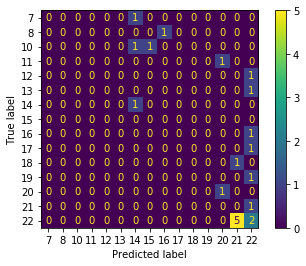

In [ ]:
# Create and show confusion matrix
plot_confusion_matrix(logisticRegr, X_test, y_test)
plt.show()  

# Update data to test on groups instead of MMSE score

In [ ]:
# Only need to replace Y values
y = np.array(merged_data["dementia_stage_num"].values).astype(np.int)

# dividing X, y into train and test data 
# 80/20 training/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print("Training data set is length: " + str(len(train)))
print("Test data set is length: " + str(len(test)))

Training data set is length: 80
Test data set is length: 21


## Updated logistic regression model

In [ ]:
# all parameters not specified are set to their defaults
logisticRegr = LogisticRegression(max_iter = 10000)
logisticRegr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
param_values = {
                'penalty' : ['l1', 'l2'],
                'C': [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]                
           }

# Try out the different n_estimators parameters
grid_search_cv = GridSearchCV(estimator = logisticRegr, param_grid = param_values, cv = None, scoring = 'accuracy') 
# A value of 'None' for cv causes this method to evaluate performance by 5-fold cross-validation

In [ ]:
grid_search_cv.fit(X_train, y_train)

best_C_value = grid_search_cv.best_params_['C']
best_penalty_value = grid_search_cv.best_params_['penalty']

print("Best C: " + str(best_C_value) + ", best penalty: " + str(best_penalty_value))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs

Best C: 0.01, best penalty: l2


In [ ]:
# Create a model with the best n_estimators value
lr_model = LogisticRegression(max_iter = 10000, penalty=best_penalty_value,C=best_C_value)
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

print(classification_report(lr_pred, y_test))

              precision    recall  f1-score   support

           0       0.17      1.00      0.29         1
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         0
           3       0.89      0.53      0.67        15
           4       0.00      0.00      0.00         0

    accuracy                           0.43        21
   macro avg       0.21      0.31      0.19        21
weighted avg       0.64      0.43      0.49        21



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


In [ ]:
print("Accuracy: ", accuracy_score(y_test, lr_pred))

0.42857142857142855
Accuracy:  0.42857142857142855


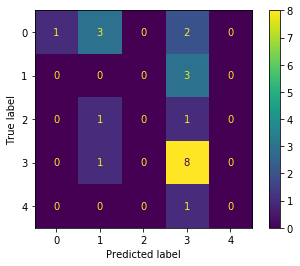

In [ ]:
# Create and show confusion matrix
plot_confusion_matrix(lr_model, X_test, y_test)
plt.show()  

# SVM multi class classification based on stage

In [ ]:
# Should be same data
# 'OVO' gets better results for some reason
# Linear kernel gets better results for some reason
clf = SVC(decision_function_shape='ovo')
clf.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
param_values = {
                'C': [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000],
                'kernel' : ['linear', 'poly', 'rbf', 'sigmoid']
           }

# Try out the different n_estimators parameters
grid_search_cv = GridSearchCV(estimator = clf, param_grid = param_values, cv = None, scoring = 'accuracy') 
# A value of 'None' for cv causes this method to evaluate performance by 5-fold cross-validation

In [ ]:
grid_search_cv.fit(X_train, y_train)

best_C_value = grid_search_cv.best_params_['C']
best_kernel_value = grid_search_cv.best_params_['kernel']

print("Best C: " + str(best_C_value) + ", best kernel: " + str(best_kernel_value))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.


Best C: 0.2, best kernel: linear


In [ ]:
# Create a model with the best n_estimators value
svm_model = SVC(C=best_C_value, decision_function_shape='ovo', kernel=best_kernel_value);
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)

print(classification_report(svm_pred, y_test))

              precision    recall  f1-score   support

           0       0.33      1.00      0.50         2
           1       0.00      0.00      0.00         7
           2       0.00      0.00      0.00         0
           3       0.67      0.50      0.57        12
           4       0.00      0.00      0.00         0

    accuracy                           0.38        21
   macro avg       0.20      0.30      0.21        21
weighted avg       0.41      0.38      0.37        21



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


In [ ]:
print("Accuracy: ", accuracy_score(y_test, svm_pred))

Accuracy:  0.38095238095238093


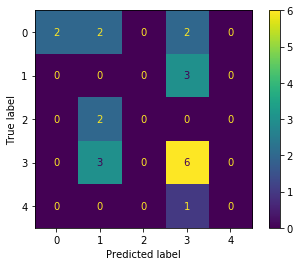

In [ ]:
# Create and show confusion matrix
plot_confusion_matrix(svm_model, X_test, y_test)
plt.show()  

# Random forest classifier

In [ ]:
# creating a RF classifier 
random_forest = RandomForestClassifier()   
  
# Training the model on the training dataset 
# fit function is used to train the model using the training sets as parameters 
random_forest.fit(X_train, y_train) 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
n_estimators_values = {'n_estimators': [10, 20, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}

# Try out the different n_estimators parameters
grid_search_cv = GridSearchCV(estimator = random_forest, param_grid = n_estimators_values, cv = None, scoring = 'accuracy') 
# A value of 'None' for cv causes this method to evaluate performance by 5-fold cross-validation

In [ ]:
grid_search_cv.fit(X_train, y_train)

best_n_estimators = grid_search_cv.best_params_['n_estimators']
best_n_estimators

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.


20

In [ ]:
# Create a model with the best n_estimators value
rf_model = RandomForestClassifier(n_estimators = best_n_estimators);
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_predict_proba = rf_model.predict_proba(X_test)

print(classification_report(rf_pred, y_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.33      0.12      0.18         8
           2       0.00      0.00      0.00         0
           3       0.67      0.50      0.57        12
           4       0.00      0.00      0.00         0

    accuracy                           0.33        21
   macro avg       0.20      0.12      0.15        21
weighted avg       0.51      0.33      0.40        21



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


In [ ]:
# using metrics module for accuracy calculation 
print("ACCURACY OF THE MODEL: ", accuracy_score(y_test, rf_pred)) 

ACCURACY OF THE MODEL:  0.3333333333333333


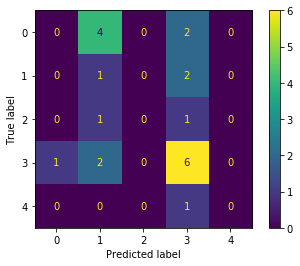

In [ ]:
# Create and show confusion matrix
plot_confusion_matrix(rf_model, X_test, y_test)
plt.show()  

# Neural net

In [ ]:
# Create a default model to track the best model
best_model =  MLPClassifier(hidden_layer_sizes = (1,), max_iter = 1000);
best_model.fit(X_train, y_train)
best_score = best_model.score(X_test, y_test)
best_hidden_layer_size = (1,)

# Create a neural net model with one hidden layer, iterating through hidden layer sizes
for hidden_layer_size in range(1, 100):
    model = MLPClassifier(hidden_layer_sizes = (hidden_layer_size,), max_iter = 1000);
    model.fit(X_train, y_train)
    model_score = model.score(X_test, y_test)
    
    if model_score > best_score:
        best_model = model;
        best_score = model_score
        best_hidden_layer_size = (hidden_layer_size, )
    
# Print the classification report for the best NN model that we have come up with
mlp_model = best_model
mlp_pred = mlp_model.predict(X_test)

print("The hidden layer size of our best-performing neural network in this experiment is: " + str(best_hidden_layer_size))
print(classification_report(mlp_pred, y_test))

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

The hidden layer size of our best-performing neural network in this experiment is: (7,)
              precision    recall  f1-score   support

           0       0.50      0.60      0.55         5
           1       0.67      0.29      0.40         7
           2       0.00      0.00      0.00         2
           3       0.44      0.67      0.53         6
           4       0.00      0.00      0.00         1

    accuracy                           0.43        21
   macro avg       0.32      0.31      0.30        21
weighted avg       0.47      0.43      0.42        21



In [ ]:
# using metrics module for accuracy calculation 
print("ACCURACY OF THE MODEL: ", accuracy_score(y_test, mlp_pred))

ACCURACY OF THE MODEL:  0.42857142857142855


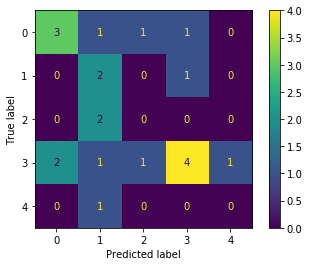

In [ ]:
# Create and show confusion matrix
plot_confusion_matrix(mlp_model, X_test, y_test)
plt.show()  

# Chain models

In [ ]:
# TODO cross validate for models
def create_stacked():
    estimators = [
        ('rf',  RandomForestClassifier(n_estimators=10, random_state=42)),
        ('svm', SVC(C=1, decision_function_shape='ovo', kernel='linear')),
        ('nn', MLPClassifier(hidden_layer_sizes = (79,), max_iter = 1000)),
        ('lr', LogisticRegression(max_iter=10000))
    ]
    return StackingClassifier(estimators=estimators)

clf = create_stacked()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print(classification_report(pred, y_test))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.


In [ ]:
# using metrics module for accuracy calculation 
print("ACCURACY OF THE MODEL: ", accuracy_score(y_test, pred))

In [ ]:
# Create and show confusion matrix
plot_confusion_matrix(clf, X_test, y_test)
plt.show()  

# TODO separate out people's voices